In [34]:
import torchvision
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import cv2

In [26]:
class MSCTD(Dataset):
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_image=True, has_text=True, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        """
        :param root: root path of the dataset
        :param split: train, dev, test
        :param image_transform: transform for image
        :param text_transform: transform for text
        :param sentiment_transform: transform for sentiment
        :param has_image: if the dataset has image
        :param has_text: if the dataset has text
        :param text_path: path of the text file
        :param image_path: path of the image folder
        :param sentiment_path: path of the sentiment file
        :param image_index_path: path of the image index file

        :return: combination of image, sentiment, text, image_index
        """
        self.root = root
        self.split = split
        if has_image:
            self.image = []
            self.image_transform = image_transform
            if image_path is None:
                self.image_path = os.path.join(root, split, 'image')
            else:
                self.image_path = os.path.join(root, image_path)
        if has_text:
            self.text = []
            self.text_transform = text_transform
            if text_path is None:
                self.text_path = os.path.join(root, split, 'english_' + split + '.txt')
            else:
                self.text_path = os.path.join(root, text_path)
        if sentiment_path is None:
            self.sentiment_path = os.path.join(root, split, 'sentiment_' + split + '.txt')
        else:
            self.sentiment_path = os.path.join(root, sentiment_path)
        if image_index_path is None:
            self.image_index_path = os.path.join(root, split, 'image_index_' + split + '.txt')
        else:
            self.image_index_path = os.path.join(root, image_index_path)
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        with open(self.sentiment_path, 'r') as f:
            for line in f:
                self.sentiment.append(int(line.strip()))
        if hasattr(self, 'text'):
            with open(self.text_path, 'r') as f:
                for line in f:
                    self.text.append(line.strip())
        with open(self.image_index_path, 'r') as f:
            for line in f:
                index = line.strip()[1:-1].split(', ')
                index = [int(i) for i in index]
                self.image_index.append(index)
        # if the class has image attribute, append image to self.image
        # the method to load images must not result in a too many open files error
        # use read_image instead of Image.open
        # the images are in self.image_path
                    
    def __getitem__(self, index):
        if hasattr(self, 'image'):
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if hasattr(self, 'text'):
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        sentiment = self.sentiment[index]
        # image_index = self.image_index[index]
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        # if the class has image and text attribute return image, text, sentiment
        if hasattr(self, 'image') and hasattr(self, 'text'):
            return image, text, sentiment
        # if the class has image attribute return image, sentiment
        elif hasattr(self, 'image'):
            return image, sentiment
        # if the class has text attribute return text, sentiment
        elif hasattr(self, 'text'):
            return text, sentiment
        else:
            raise Exception('Either has_image or has_text should be True')


    def __len__(self):
        return len(self.sentiment)
    

In [27]:
MSCTD_train = MSCTD(root='data', split='train')
MSCTD_dev = MSCTD(root='data', split='dev')
MSCTD_test = MSCTD(root='data', split='test')

In [28]:
# create a dataframe for each split
train_df = pd.DataFrame({'text': MSCTD_train.text, 'sentiment': MSCTD_train.sentiment})
dev_df = pd.DataFrame({'text': MSCTD_dev.text, 'sentiment': MSCTD_dev.sentiment})
test_df = pd.DataFrame({'text': MSCTD_test.text, 'sentiment': MSCTD_test.sentiment})

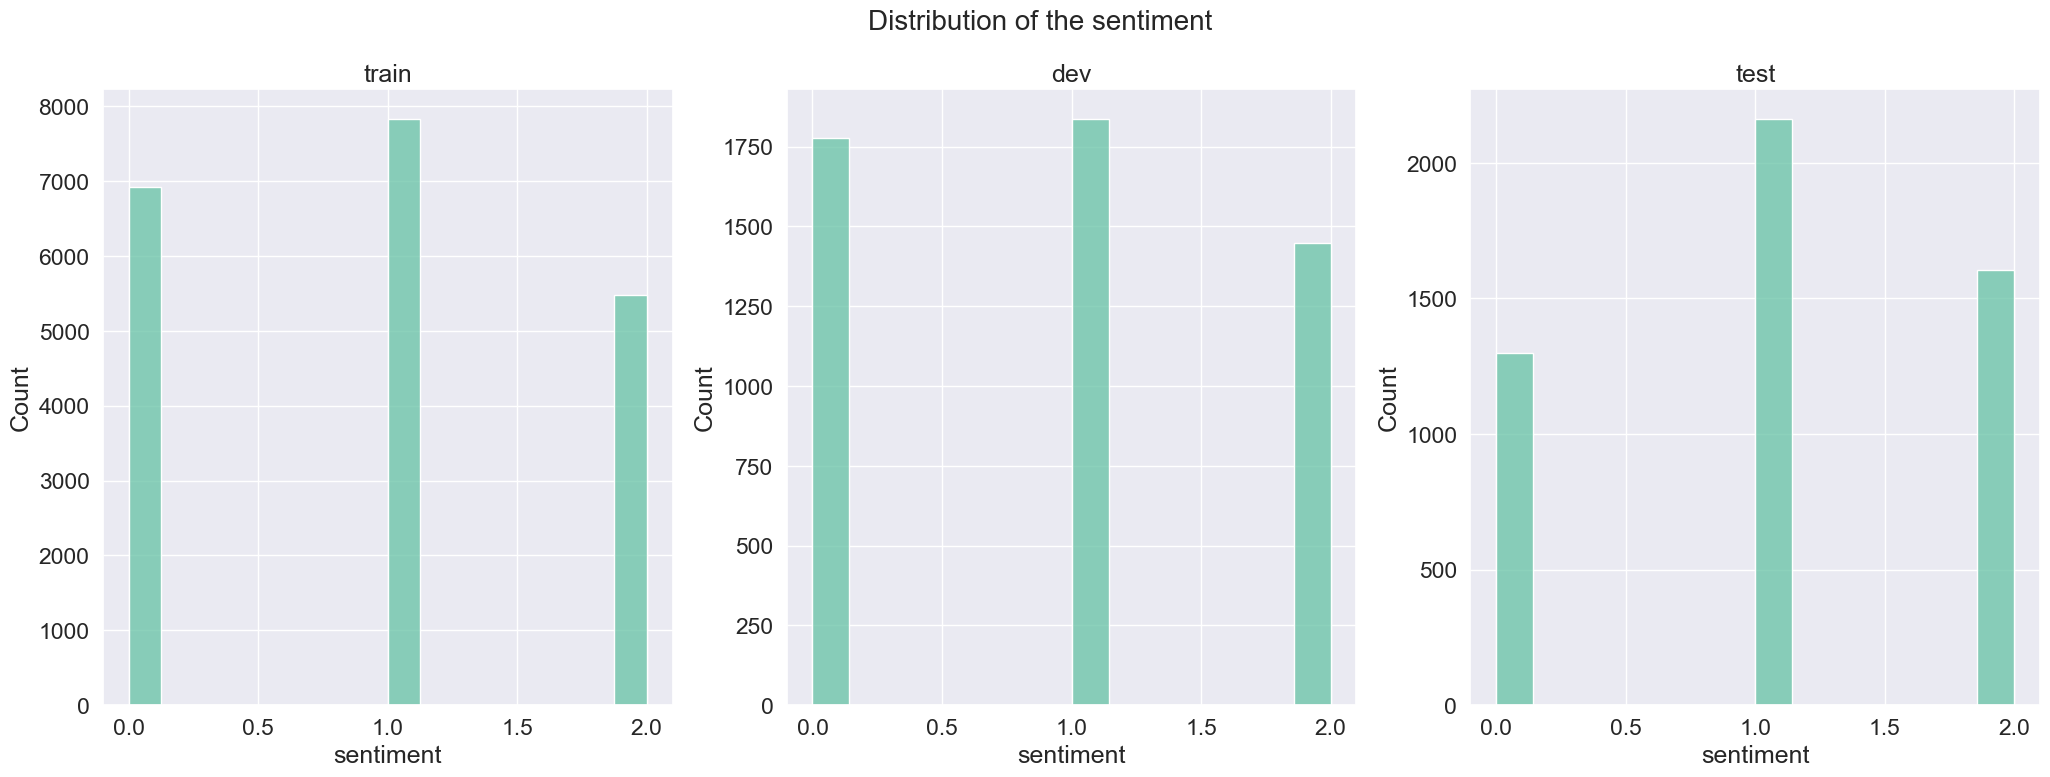

In [29]:
# plot the distribution of the sentiment
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
sns.set_palette("Set2")
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Distribution of the sentiment', fontsize=20)
sns.histplot(train_df['sentiment'], ax=ax[0])
ax[0].set_title('train')
sns.histplot(dev_df['sentiment'], ax=ax[1])
ax[1].set_title('dev')
sns.histplot(test_df['sentiment'], ax=ax[2])
ax[2].set_title('test')
plt.show()



In [30]:
# add a new column to the dataframe with the length of the text
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
dev_df['text_length'] = dev_df['text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))

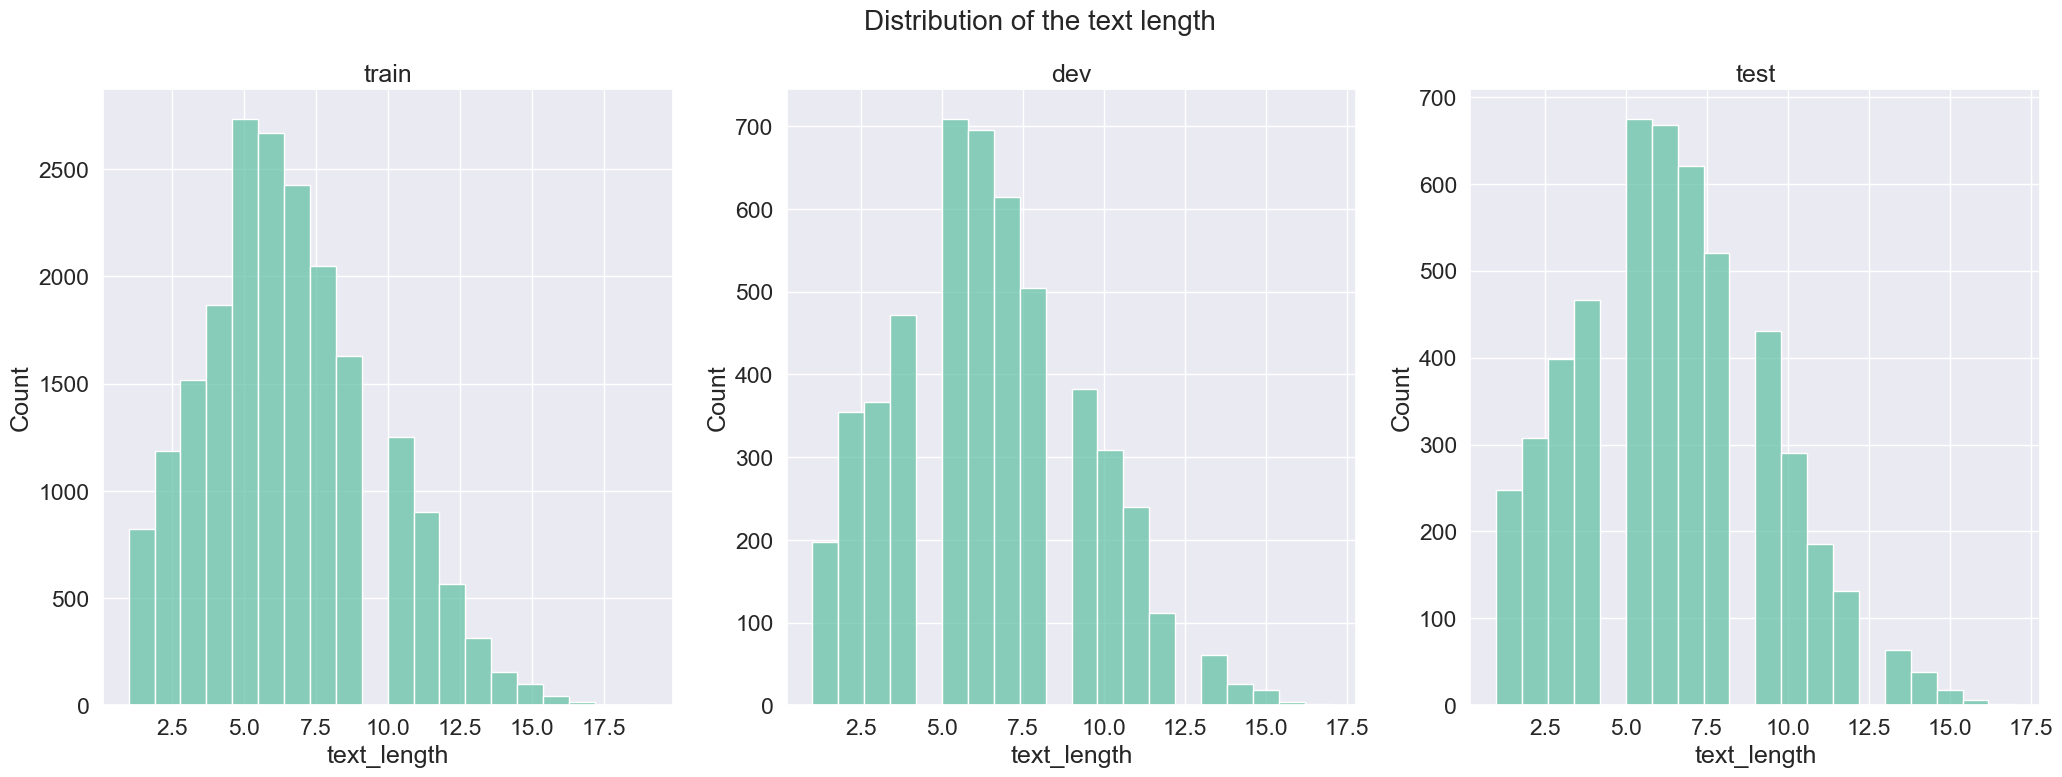

train mean:  6.4644268774703555
train std:  3.0410046435586535
dev mean:  6.310290341694648
dev std:  2.9381055492157224
test mean:  6.303927373199132
test std:  2.9823785621767294


In [31]:
# plot the distribution of the text length
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Distribution of the text length', fontsize=20)
sns.histplot(train_df['text_length'], ax=ax[0], bins=20)
ax[0].set_title('train')
sns.histplot(dev_df['text_length'], ax=ax[1], bins=20)
ax[1].set_title('dev')
sns.histplot(test_df['text_length'], ax=ax[2], bins=20)
ax[2].set_title('test')
plt.show()
# print the mean and standard deviation of the text length
print('train mean: ', train_df['text_length'].mean())
print('train std: ', train_df['text_length'].std())
print('dev mean: ', dev_df['text_length'].mean())
print('dev std: ', dev_df['text_length'].std())
print('test mean: ', test_df['text_length'].mean())
print('test std: ', test_df['text_length'].std())

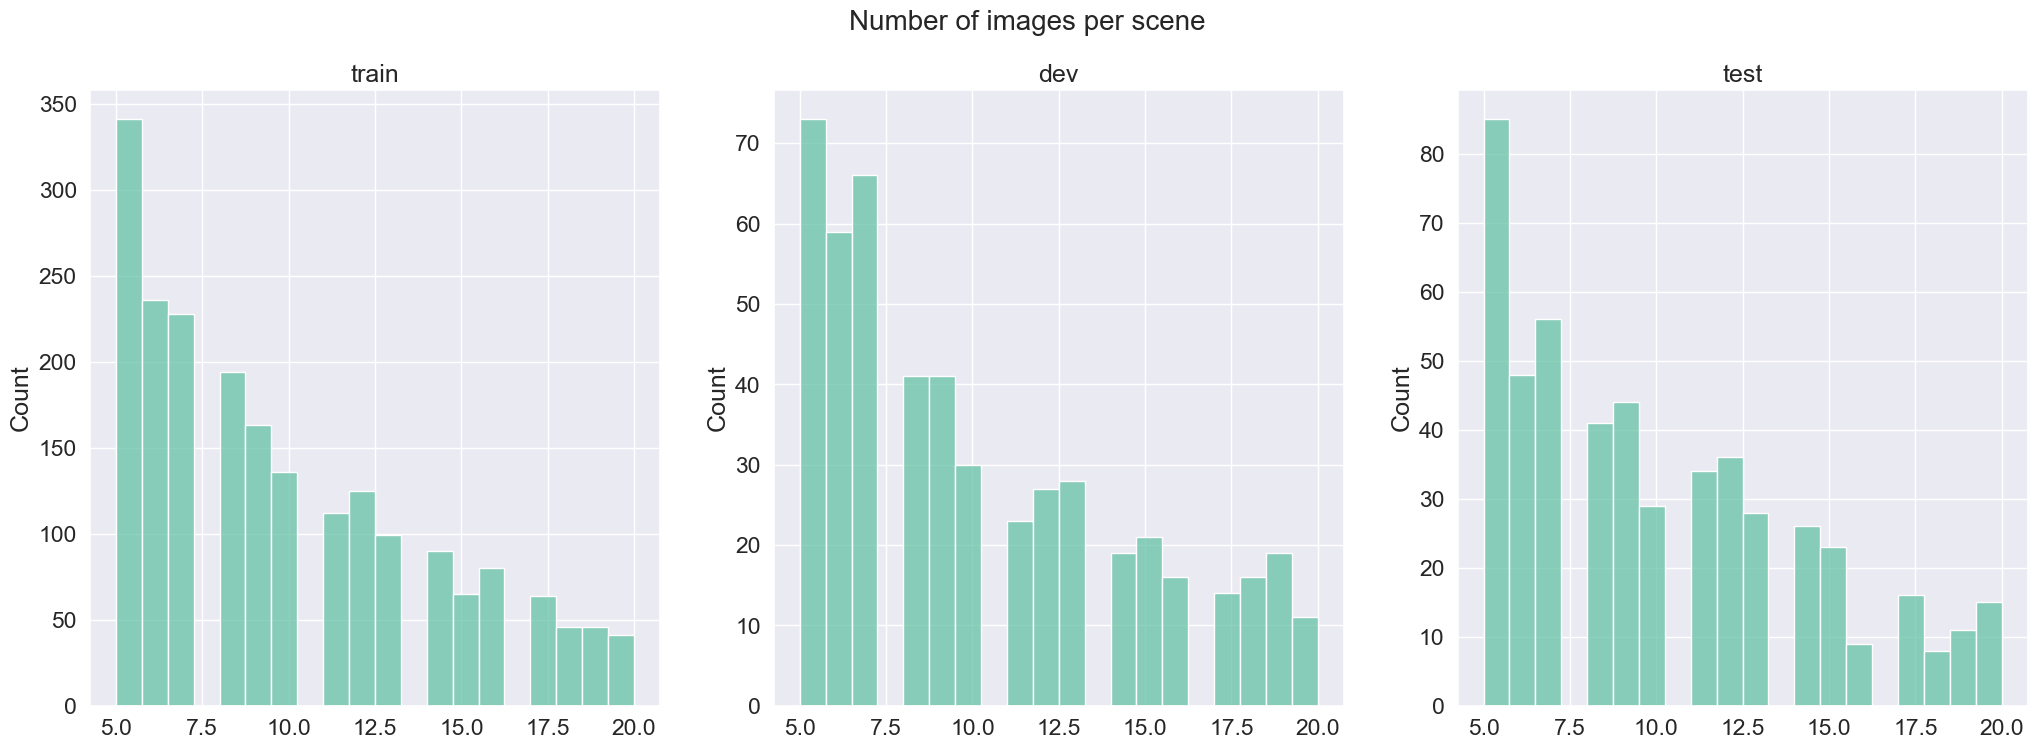

train mean:  9.796708615682478
train std:  4.206700598078209
dev mean:  10.045634920634921
dev std:  4.3879231801583565
test mean:  9.954813359528487
test std:  4.213357164986483


In [32]:
train_imgs_per_scene = [len(i) for i in MSCTD_train.image_index]
dev_imgs_per_scene = [len(i) for i in MSCTD_dev.image_index]
test_imgs_per_scene = [len(i) for i in MSCTD_test.image_index]
# plot the distribution of the number of images per scene
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Number of images per scene', fontsize=20)
sns.histplot(train_imgs_per_scene, ax=ax[0], bins=20)
ax[0].set_title('train')
sns.histplot(dev_imgs_per_scene, ax=ax[1], bins=20)
ax[1].set_title('dev')
sns.histplot(test_imgs_per_scene, ax=ax[2], bins=20)
ax[2].set_title('test')
plt.show()
print('train mean: ', np.mean(train_imgs_per_scene))
print('train std: ', np.std(train_imgs_per_scene))
print('dev mean: ', np.mean(dev_imgs_per_scene))
print('dev std: ', np.std(dev_imgs_per_scene))
print('test mean: ', np.mean(test_imgs_per_scene))
print('test std: ', np.std(test_imgs_per_scene))

In [39]:
# use haar cascade to detect faces in the images
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# use the face detector to detect faces in the images
def detect_faces(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(image, 1.3, 5)
    return len(faces)

train_faces_per_img = [detect_faces(MSCTD_train[i][0].numpy()) for i in range(len(MSCTD_train))]

error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x39480f9d::Set<1,-1,-1>,struct cv::impl::A0x39480f9d::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [38]:
MSCTD_test[1][0].numpy()

array([[[ 10,  10,  10, ...,  11,  12,  12],
        [ 10,  10,  10, ...,  13,  13,  15],
        [ 12,  12,  12, ...,  13,  16,  22],
        ...,
        [  5,   5,   5, ...,  95,  95,  95],
        [  5,   5,   5, ...,  95,  96,  96],
        [  5,   5,   5, ...,  94,  94,  94]],

       [[ 11,  11,  11, ...,  10,   8,   8],
        [ 11,  11,  11, ...,   9,   9,  10],
        [ 13,  13,  13, ...,   9,  11,  14],
        ...,
        [  5,   5,   5, ..., 114, 114, 114],
        [  5,   5,   5, ..., 114, 115, 115],
        [  5,   5,   5, ..., 113, 113, 113]],

       [[  5,   5,   5, ...,   8,   7,   7],
        [  5,   5,   5, ...,   6,   6,   7],
        [  7,   7,   7, ...,   6,   8,  12],
        ...,
        [  5,   5,   5, ..., 120, 120, 120],
        [  5,   5,   5, ..., 120, 121, 121],
        [  5,   5,   5, ..., 119, 119, 119]]], dtype=uint8)